# Leitura de dados

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [6]:
df = pd.read_csv('data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'

## Análise exploratória

In [3]:
...

Ellipsis

## Separação treino e teste

In [4]:
from sklearn.model_selection import train_test_split

SEED = 42
test_size = 0.2

train_df, test_df = train_test_split(
    df,
    test_size=test_size,
    stratify=df['Grade'], # mantém a mesma porcentagem das classes de Grade no conjunto de treino e teste
    random_state=SEED,
)

NameError: name 'df' is not defined

# Regressão

In [3]:
# Separando as features e o target
X_train = train_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1) #dropando todos os targets
y_train = train_df['Grade_numerical']

X_test = test_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1)
y_test = test_df['Grade_numerical']

NameError: name 'train_df' is not defined

## Construção do modelo

In [ ]:
# Separando as colunas de acordo com o seu tipo para facilitar o pré-processamento

def get_column_names():
    numerical_columns = [
        'Student_Age',
        'Weekly_Study_Hours',
    ]

    categorical_columns = [
        'Student_Age',
        'Sex',
        'Scholarship',
        'Transportation',
        'High_School_Type',
        'Project_work',
        'Additional_Work',
        'Sports_activity',
        'Weekly_Study_Hours',
        'Attendance',
        'Reading',
        'Notes',
        'Listening_in_Class',
    ]

    return numerical_columns, categorical_columns

### Modelo Trivial

Existem dois modelos triviais, e que devem ser testados como benchmark de má resultado, o RAW Linear Regression e o DummyRegression

In [ ]:
from sklearn.dummy import DummyRegressor

# Modelo trivial
def create_dummy_model():
    return DummyRegressor(strategy='mean')

### Modelo simples

In [ ]:
from sklearn.compose import ColumnTransformer # Classe utilizada para aplicar transformações diferentes em colunas diferentes
from sklearn.impute import SimpleImputer # Classe utilizada para preencher valores faltantes
from sklearn.linear_model import LinearRegression # Modelo de regressão linear
from sklearn.pipeline import Pipeline # Classe utilizada para encadear transformações
from sklearn.preprocessing import OneHotEncoder # Classe utilizada para codificar variáveis categóricas, aplicado com drop='first' para evitar a multicolinearidade


# Modelo simples: regressão linear
def create_simple_model():
    numerical_columns, categorical_columns = get_column_names()

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder',
         OneHotEncoder(
             handle_unknown='ignore',
             drop='first',
             sparse_output=False,
         )),
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns),
    ],)

    model = LinearRegression()

    simple_model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model),
    ])

    return simple_model

### Modelo complexo

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


def create_complex_model():
    numerical_columns, categorical_columns = get_column_names()

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder',
         OneHotEncoder(
             handle_unknown='ignore',
             drop='first',
             sparse_output=False,
         )),
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns),
    ],)

    model = HistGradientBoostingRegressor(max_depth=5, max_iter=100)

    complex_model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model),
    ])

    return complex_model

#### Treinando os modelos

In [ ]:
dummmy_model = create_dummy_model()
simple_model = create_simple_model()
complex_model = create_complex_model()

models = {
    'dummy': {
        'model': dummmy_model,
    },
    'simple': {
        'model': simple_model,
    },
    'complex': {
        'model': complex_model,
    },
}

## Escolha do modelo
### 1. train_val, test_val

A escolha do modelo por amostra de validação é interessante, tendo em vista que você não contamina a amostra de teste, fazendo uma nova separação dentro do próprio conjunto de treinamento, no entanto você fica limitado a ter apenas mais um ponto de vista, inclusive podendo sofrer caso seu conjunto possua uma baixa quantidade de observações

In [ ]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=SEED,
)

from sklearn.metrics import root_mean_squared_error

for model_name, model_item in models.items():
    model = model_item['model']
    
    model.fit(X_train_val, y_train_val)

    y_train_pred = model.predict(X_train_val)
    rmse_train = root_mean_squared_error(y_train_val, y_train_pred)

    y_test_pred = model.predict(X_test_val)
    rmse_test = root_mean_squared_error(y_test_val, y_test_pred)

    print(f'{model_name} model:')
    print(f'  - RMSE (train): {rmse_train:.2f}')
    print(f'  - RMSE (test): {rmse_test:.2f}')
    print()


### 2. Validação cruzada

A validação cruzada é ótima em situações que você possui um conjunto de observações pequeno, consistindo na separação do seu conjunto de treinamento em N partes, e você testa seu modelo N vezes, sempre treinando com N-1 e testando no 1/N

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
CV = 3

In [ ]:
#aqui o funcionamento para chegar nos parâmetros a serem testados, você faz o caminho total até chegar nele
# 1. Nome do pipeline
# 2. Nome do passo do pipeline
# 3. Nome do hiperparâmetro
# 4. Valores do hiperparâmetro em lista

# * caso você não tenha feito um pipeline, você pode pular o passo 1 e 2

param_grid_dummy = {
    'strategy': ['mean', 'median'],
}

param_grid_simple = {
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
}

param_grid_complex = {
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
    'preprocessing__num__poly__degree': [1, 2, 3],
    'model__max_depth': [3, 5, 7],
    'model__max_iter': [50, 100, 200],
}

params = {
    'dummy': param_grid_dummy,
    'simple': param_grid_simple,
    'complex': param_grid_complex,
}

In [ ]:
for model_name, model_item in models.items():
    model = model_item['model']
    param_grid = params[model_name]

    model_item['grid_search'] = GridSearchCV(
        model,
        param_grid,
        cv=CV,
        scoring='neg_root_mean_squared_error', # o GridSearchCV utiliza o valor negativo do RMSE para maximizar o valor da métrica, e alcançar o mais próximo de zero
        n_jobs=-1,
        return_train_score=True,
    )

In [ ]:
for model_name, model_item in models.items():
    grid_search = model_item['grid_search']
    grid_search.fit(X_train, y_train)

/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_pro

In [ ]:
for model_name, model_item in models.items():
    grid_search = model_item['grid_search']

    print(f'{model_name} model:')
    print(f'  - Hyperparameters search: {grid_search.param_grid}')
    print()
    print(f'  - Best hyperparameters: {grid_search.best_params_}')
    print(f'  - Best RMSE score: {-grid_search.best_score_:.2f}')
    print()

    df_results = pd.DataFrame(grid_search.cv_results_)
    df_results = df_results.sort_values(by='rank_test_score')
    display(-df_results[['mean_train_score', 'mean_test_score']].iloc[1, :].round(3))

dummy model:
  - Hyperparameters search: {'strategy': ['mean', 'median']}

  - Best hyperparameters: {'strategy': 'mean'}
  - Best RMSE score: 2.40



mean_train_score    2.498
mean_test_score     2.494
Name: 1, dtype: float64

simple model:
  - Hyperparameters search: {'preprocessing__num__imputer__strategy': ['mean', 'median']}

  - Best hyperparameters: {'preprocessing__num__imputer__strategy': 'mean'}
  - Best RMSE score: 2.78



mean_train_score    1.693
mean_test_score     2.784
Name: 1, dtype: float64

complex model:
  - Hyperparameters search: {'preprocessing__num__imputer__strategy': ['mean', 'median'], 'preprocessing__num__poly__degree': [1, 2, 3], 'model__max_depth': [3, 5, 7], 'model__max_iter': [50, 100, 200]}

  - Best hyperparameters: {'model__max_depth': 3, 'model__max_iter': 100, 'preprocessing__num__imputer__strategy': 'mean', 'preprocessing__num__poly__degree': 1}
  - Best RMSE score: 2.44



mean_train_score    1.874
mean_test_score     2.439
Name: 9, dtype: float64

O melhor modelo encontrado com o GridSearchCV pode ser apresentado a com o seguinte código

In [ ]:
best_model = models['complex']['grid_search'].best_estimator_

## Certificação

A etapa de certificação é o momento em que o modelo está "pronto", não sofrerá nenhum outro ajuste, e o Data expert e o Business expert sentam, treinam com o conjunto de treino, testam com o conjunto de teste e avaliam se o modelo está suficientemente bom para implantação, se não, é necessário reiniciar todo o processo do CRISP-DM

In [ ]:
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print(f'Best model:')
print(f'  - RMSE (test): {rmse_test:.2f}')
print()

# Classificação

In [2]:
# Fazemos a separação treino e teste da mesma forma que fizemos anteriormente, mas agora para o target binário
# e utilizamos o target binário para treinar o modelo

X_train = train_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1)
y_train = train_df['Grade_binary']

X_test = test_df.drop(['Grade', 'Grade_numerical', 'Grade_binary'], axis=1)
y_test = test_df['Grade_binary']

NameError: name 'train_df' is not defined

In [1]:
# Aqui treinamos um modelo complexo para classificação, com o HistGradientBoosting, assim como fizemos anteriormente, porém agora no seu modelo de classificação

from sklearn.ensemble import HistGradientBoostingClassifier

def create_complex_model_classification():
    numerical_columns, categorical_columns = get_column_names()

    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ])

    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder',
         OneHotEncoder(
             handle_unknown='ignore',
             drop='first',
             sparse_output=False,
         )),
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns),
    ],)

    model = HistGradientBoostingClassifier(max_depth=5, max_iter=100)

    complex_model = Pipeline([
        ('preprocessing', preprocessing),
        ('model', model),
    ])

    return complex_model

In [ ]:
classifier = create_complex_model_classification()

In [ ]:
classifier.fit(X_train, y_train)

y_test_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score
# A acurácia é uma das métricas de classificação que nós temos, sendo a proporção de acertos do modelo
# Ela é calculada como a razão entre o número de acertos e o número total de exemplo

accuracy = accuracy_score(y_test, y_test_pred)

accuracy

0.9310344827586207

/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/fjayres/dev/ml_prova/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


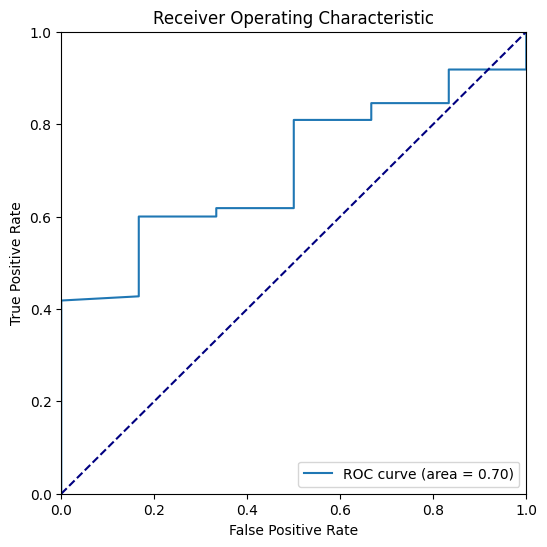

array([[ 1,  1],
       [ 1, 26]])

In [ ]:
from sklearn.model_selection import cross_val_predict

# Aqui, o cross_val_predict é utilizado para fazer a validação cruzada do modelo, e obter as probabilidades de cada classe
# O método utilizado é o predict_proba, que retorna a probabilidade de cada exemplo pertencer a cada classe
# Aqui, não temos a exploração dos hiperparâmetros, mas é uma forma de avaliar o modelo utilizando o cross_validation

y_train_pred = cross_val_predict(classifier, X_train, y_train, cv=CV, method='predict_proba')

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# Outras métricas para modelos de classificação são a curva ROC e a área sob a curva ROC (AUC)
# A curva ROC é um gráfico que mostra a relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos
# A AUC é a área sob a curva ROC, e é uma métrica que varia entre 0.5 e 1, sendo 0.5 o valor de um modelo aleatório

# A taxa de verdadeiros positivos (TPR) é a razão entre o número de positivos classificados como positivos e o número total de positivos
# A taxa de falsos positivos (FPR) é a razão entre o número de negativos classificados como positivos e o número total de negativos

fpf, tpf, _ = roc_curve(y_train, y_train_pred[:, 1])
roc_auc = roc_auc_score(y_train, y_train_pred[:, 1])

plt.figure(figsize=(6, 6))
plt.plot(fpf, tpf, label=f'ROC curve (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

plt.show()

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

### Métricas de desempenho de classificação
Precision é a razão entre os acertos feitos nas previsões positivas e o total de previsões positivas realizadas. Em outras palavras, é uma medida de seletividade, que indica quantas das vezes que o modelo previu uma classe positiva, ele estava correto.

Recall, por sua vez, é a razão entre os acertos feitos nas previsões positivas e o total real de casos positivos. Assim, ele mede a abrangência do modelo, mostrando a capacidade de identificar todos os casos positivos.

Existe um trade-off entre precision e recall: normalmente, ao ajustar o modelo para aumentar a precision (ou seja, ser mais seletivo), o modelo tende a perder recall, deixando de identificar alguns casos positivos. Da mesma forma, se o objetivo é maximizar o recall (capturando a maioria dos positivos), a precisão pode diminuir. O equilíbrio entre essas métricas depende do contexto e dos objetivos do problema em questão.

*Sempre podemos alcançar um recall de 100%, apenas categorizando todos como positivo. Porém nesse caso o precision será a % de positivos no dataset